# Train Model

Notebook to play with model training. 

For the official training refer to model_train.py file in optosim.

In [23]:
# For autoreloading the classes so you do not need to restart the kernel
%load_ext autoreload
%autoreload 2

In [24]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
import json

import optosim 

from optosim.settings import DATA_DIR, MODEL_DIR

from optosim.simulation.event_reader import EventReader, show_data

from optosim.super_resolution.model import SuperResolutionModel
from optosim.super_resolution.model import create_datasets

import optosim.super_resolution.model_utils as model_utils

from optosim.model_train import read_events, get_model_parameters


In [25]:
show_data(DATA_DIR)

Found 1 subdirectories
Subdirectories:
['mc0003']


,subdir,detector,nevents,nphoton_per_event,radius
0,mc0003,XAMS,10,"[1000, 25000]",3.2


In [26]:
run_id = 'mc0003'
nmax = 100_000
pmts_per_dim = 5

# read data
run_id_dir = os.path.join(DATA_DIR, run_id)
files = glob.glob(run_id_dir + '/*.hd5f')

print(f"Reading data from {run_id_dir}")
print(f"Found {len(files)} files")

true_pos, fine_top, top = read_events(files, nmax=nmax)
    

Reading data from /data/xenon/cfuselli/optosim_data/data/mc0003
Found 10 files
number of files:  10
Found 1 subdirectories
Subdirectories:
['mc0003']
processed  0 events
We have 100 events
low res PMT has shape (2, 2)
high res truth has shape (20, 20)
true positions have shape (3,)


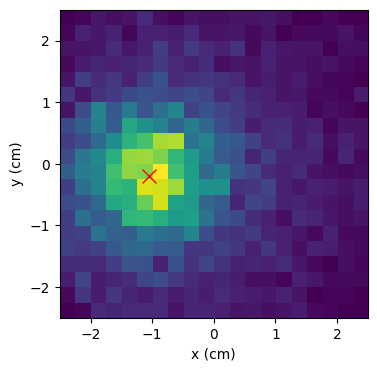

In [27]:
# check if data is ok

r = 2.5

num = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(
    top[num], interpolation="nearest", origin="lower", extent=[-r, r, -r, r]
)

ax.imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-2.5, 2.5, -2.5, 2.5],
)

ax.plot(
    true_pos[num][0],
    true_pos[num][1],
    marker="x",
    markersize=10,
    color="red",
    label="true position",
)

plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

In [28]:
# create train and test sets
y = fine_top # downsample if wanted
X = top
pos = [pos[:2] for pos in true_pos] # depth is not used

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(
    X, y, pos, train_fraction=0.8
)

y_train_downsampled = model_utils.downsample_heatmaps_to_dimensions(y_train, pmts_per_dim, pmts_per_dim)
y_test_downsampled = model_utils.downsample_heatmaps_to_dimensions(y_test, pmts_per_dim, pmts_per_dim)

In [29]:
low_to_high_res_net_params = {
    "hidden_layer_sizes":(100,100),
    "activation":"relu", 
    "solver":"adam", 
    "alpha":0.0001, 
    "batch_size":"auto", 
    "learning_rate":"constant", 
    "learning_rate_init":0.001, 
    "power_t":0.5, 
    "max_iter":200, 
    "shuffle":True, 
    "random_state":None, 
    "tol":1e-4, 
    "verbose":False, 
    "warm_start":False, 
    "momentum":0.9, 
    "nesterovs_momentum":True, 
    "early_stopping":True, 
    "validation_fraction":0.1, 
    "beta_1":0.9, 
    "beta_2":0.999, 
    "epsilon":1e-8, 
    "n_iter_no_change":10, 
    "max_fun":15000
    }

high_res_to_true_net_params = {
    "hidden_layer_sizes":(100,),
    "activation":"relu", 
    "solver":"adam", 
    "alpha":0.0001, 
    "batch_size":"auto", 
    "learning_rate":"constant", 
    "learning_rate_init":0.001, 
    "power_t":0.5, 
    "max_iter":200, 
    "shuffle":True, 
    "random_state":None, 
    "tol":1e-4, 
    "verbose":False, 
    "warm_start":False, 
    "momentum":0.9, 
    "nesterovs_momentum":True, 
    "early_stopping":True, 
    "validation_fraction":0.1, 
    "beta_1":0.9, 
    "beta_2":0.999, 
    "epsilon":1e-8, 
    "n_iter_no_change":10, 
    "max_fun":15000
    }

# can also read from the file
# low_to_high_res_net_params, high_res_to_true_net_params = get_model_parameters()


model = SuperResolutionModel(
    low_to_high_res_net_params=low_to_high_res_net_params,
    high_res_to_true_net_params=high_res_to_true_net_params
)


In [30]:
model.train(X_train, y_train_downsampled, pos_train)

/user/cfuselli/cfuselli/software/OptoSim/venv_optosim/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


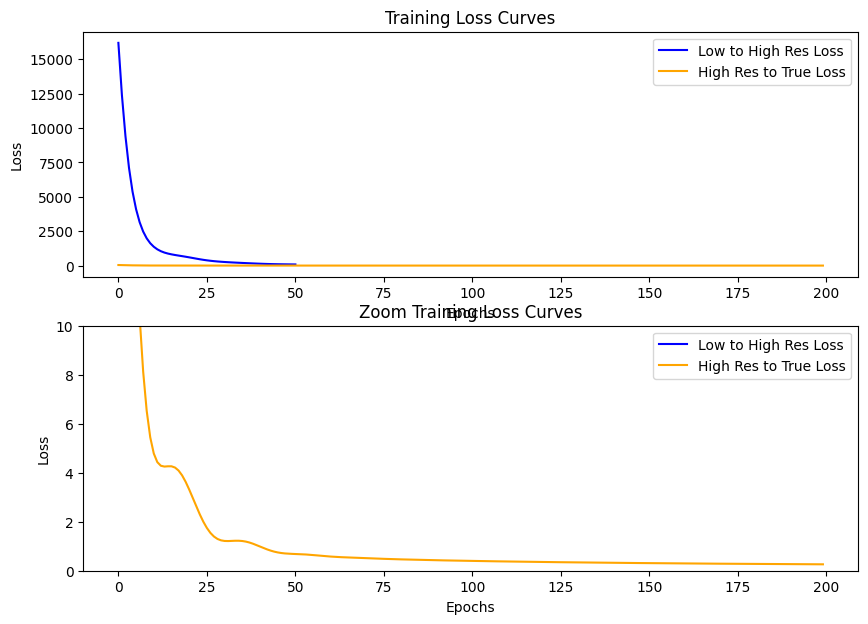

In [31]:
model.plot_loss_curve()